# DCGAN

This notebook demonstrates the use of a Deep Convolutional GAN trained on the MNIST dataset.

## Install and Import packages

In [1]:
# %pip install numpy torch torchvision torch-summary Pillow ipython seaborn imageio

In [2]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn

from IPython.display import Video, display
from PIL import Image
from torchsummary import summary
from torchvision import datasets, transforms
from typing import Any, List, Optional, Union

Set fixed seed for reproducibility

In [3]:
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

## Helper functions

In [4]:
def pt_to_numpy(images: torch.FloatTensor) -> np.ndarray:
    return images.detach().cpu().permute(0, 2, 3, 1).float().numpy()


def numpy_to_pt(images: np.ndarray) -> torch.FloatTensor:
    if images.ndim == 3:
        images = images[..., None]
    return torch.from_numpy(images.transpose(0, 3, 1, 2))


def numpy_to_pil(images: np.ndarray) -> Image.Image:
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]
    return pil_images


def pil_to_numpy(images: Union[List[Image.Image], Image.Image]) -> np.ndarray:
    if not isinstance(images, Image.Image) and not isinstance(images, list):
        raise ValueError(
            f"Expected PIL image or list of PIL images, got {type(images)}."
        )
    if not isinstance(images, list):
        images = [images]
    images = [np.array(image).astype(np.float32) / 255.0 for image in images]
    images = np.stack(images, axis=0)
    return images


def normalize(images: torch.FloatTensor) -> torch.FloatTensor:
    return 2.0 * images - 1.0


def denormalize(images: torch.FloatTensor) -> torch.FloatTensor:
    return (0.5 + images / 2).clamp(0, 1)


def pil_to_video(images: List[Image.Image], filename: str, fps: int = 60) -> None:
    frames = [np.array(image) for image in images]
    with imageio.get_writer(filename, fps=fps) as video_writer:
        for frame in frames:
            video_writer.append_data(frame)


def image_grid(images: List[Image.Image], rows: int, cols: int) -> Image.Image:
    if len(images) > rows * cols:
        raise ValueError(
            f"Number of images ({len(images)}) exceeds grid size ({rows}x{cols})."
        )
    w, h = images[0].size
    grid = Image.new("L", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

### Load Dataset

Here, we load the MNIST dataset. We use a fixed subset of the dataset to speed up the training process since this is a simple demo. We convert the images to tensors and normalize values to the range [-1, 1].

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
subset_size = 20000

In [6]:
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
    ),
    download=True,
)
train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

#### Visualize training dataset

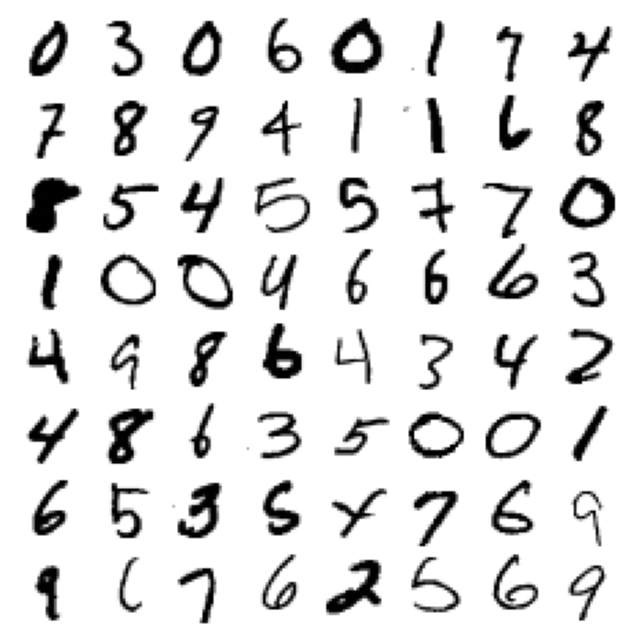

In [7]:
for batch_images, batch_labels in dataloader:
    rows = int(batch_size**0.5)
    if rows * rows < batch_size:
        rows += 1
    cols = rows
    batch_images = numpy_to_pil(pt_to_numpy(denormalize(batch_images)))
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(image_grid(batch_images, rows=rows, cols=cols), cmap="binary")
    plt.axis("off")
    plt.show()
    break

## Creating Models

We define the Generator and Discriminator - components of a GAN.

In [8]:
class Generator(nn.Module):
    def __init__(
        self,
        latent_channels: int,
        output_channels: int,
        channels: List[int],
        device: str = "cuda",
    ) -> None:
        super().__init__()

        self.latent_channels = latent_channels
        self.output_channels = output_channels
        self.channels = channels
        self.device = device

        if len(channels) != 4:
            raise ValueError(
                f"`channels` should have length 4 as this model uses 4 ConvTranspose2d layers with configurable out_channels"
            )

        def block(
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            strides: int,
            padding: int,
        ) -> nn.Sequential:
            return nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels, out_channels, kernel_size, strides, padding
                ),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.25, inplace=True),
            )

        self.model = nn.Sequential()
        self.model.append(block(latent_channels, channels[0], 4, 2, 1))
        self.model.append(block(channels[0], channels[1], 4, 2, 1))
        self.model.append(block(channels[1], channels[2], 4, 1, 0))
        self.model.append(block(channels[2], channels[3], 4, 2, 1))
        self.model.append(nn.ConvTranspose2d(channels[3], output_channels, 4, 2, 1))
        self.model.append(nn.Tanh())

        self.to(device)

        # Latent:  [B, latent_channels, 1, 1]
        # Layer 0: [B, channels[0], 2, 2]
        # Layer 1: [B, channels[1], 4, 4]
        # Layer 2: [B, channels[2], 7, 7]
        # Layer 3: [B, channels[3], 14, 14]
        # Layer 4: [B, output_channels, 28, 28]

    def forward(self, latent: torch.FloatTensor) -> torch.FloatTensor:
        latent = latent.to(self.device)

        latent = latent.view(-1, self.latent_channels, 1, 1)
        x = self.model(latent)

        return x.view(-1, 28, 28)

In [9]:
class Discriminator(nn.Module):
    def __init__(
        self,
        input_channels: int,
        output_channels: int,
        channels: List[int],
        device: str = "cuda",
    ) -> None:
        super().__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels
        self.channels = channels
        self.device = device

        if len(channels) != 4:
            raise ValueError(
                f"`channels` should have length 4 as this model uses 4 ConvTranspose2d layers with configurable out_channels"
            )

        def block(
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            strides: int,
            padding: int,
        ) -> nn.Sequential:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.25, inplace=True),
            )

        self.model = nn.Sequential()
        self.model.append(nn.Conv2d(input_channels, channels[0], 4, 2, 1))
        self.model.append(block(channels[0], channels[1], 4, 2, 1))
        self.model.append(block(channels[1], channels[2], 4, 1, 0))
        self.model.append(block(channels[2], channels[3], 4, 2, 1))
        self.model.append(nn.Conv2d(channels[3], output_channels, 4, 2, 1))
        self.model.append(nn.Sigmoid())

        self.to(device)

        # Images:  [B, 1, 28, 28]
        # Layer 0: [B, channels[0], 14, 14]
        # Layer 1: [B, channels[1], 7, 7]
        # Layer 2: [B, channels[2], 4, 4]
        # Layer 3: [B, channels[3], 2, 2]
        # Layer 4: [B, channels[4], 1, 1]

    def forward(self, images: torch.FloatTensor) -> torch.FloatTensor:
        images = images.to(self.device)

        images = images.view(-1, 1, 28, 28)
        x = self.model(images)

        return x.squeeze()

#### Configure Hyperparameters for Training

In [10]:
epochs = 25
learning_rate_g = 1e-4
learning_rate_d = 1e-4
steps_g = 3
steps_d = 3
latent_channels = 128
log_steps = 100

generator_hidden_channels = [512, 256, 128, 64]
discriminator_hidden_channels = [64, 128, 256, 512]

In [11]:
generator = Generator(
    latent_channels=latent_channels,
    output_channels=1,
    channels=generator_hidden_channels,
    device=device,
)
discriminator = Discriminator(
    input_channels=1,
    output_channels=1,
    channels=discriminator_hidden_channels,
    device=device,
)

In [12]:
_ = summary(
    generator,
    [(1, latent_channels)],
    dtypes=[torch.FloatTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 28, 28]           --
|    └─Sequential: 2-1                   [-1, 512, 2, 2]           --
|    |    └─ConvTranspose2d: 3-1         [-1, 512, 2, 2]           1,049,088
|    |    └─BatchNorm2d: 3-2             [-1, 512, 2, 2]           1,024
|    |    └─LeakyReLU: 3-3               [-1, 512, 2, 2]           --
|    └─Sequential: 2-2                   [-1, 256, 4, 4]           --
|    |    └─ConvTranspose2d: 3-4         [-1, 256, 4, 4]           2,097,408
|    |    └─BatchNorm2d: 3-5             [-1, 256, 4, 4]           512
|    |    └─LeakyReLU: 3-6               [-1, 256, 4, 4]           --
|    └─Sequential: 2-3                   [-1, 128, 7, 7]           --
|    |    └─ConvTranspose2d: 3-7         [-1, 128, 7, 7]           524,416
|    |    └─BatchNorm2d: 3-8             [-1, 128, 7, 7]           256
|    |    └─LeakyReLU: 3-9               [-1, 128, 7, 7]     

In [13]:
_ = summary(
    discriminator,
    [(1, 28, 28)],
    dtypes=[torch.FloatTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 14, 14]          1,088
|    └─Sequential: 2-2                   [-1, 128, 7, 7]           --
|    |    └─Conv2d: 3-1                  [-1, 128, 7, 7]           131,200
|    |    └─BatchNorm2d: 3-2             [-1, 128, 7, 7]           256
|    |    └─LeakyReLU: 3-3               [-1, 128, 7, 7]           --
|    └─Sequential: 2-3                   [-1, 256, 4, 4]           --
|    |    └─Conv2d: 3-4                  [-1, 256, 4, 4]           524,544
|    |    └─BatchNorm2d: 3-5             [-1, 256, 4, 4]           512
|    |    └─LeakyReLU: 3-6               [-1, 256, 4, 4]           --
|    └─Sequential: 2-4                   [-1, 512, 2, 2]           --
|    |    └─Conv2d: 3-7                  [-1, 512, 2, 2]           2,097,664
|    |    └─BatchNorm2d: 3-8             [-1, 512, 2, 2]       

## Training

In [14]:
loss = nn.BCELoss()
optim_g = torch.optim.AdamW(generator.parameters(), lr=learning_rate_g)
optim_d = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate_d)

In [15]:
def trainstep_g():
    optim_g.zero_grad()

    latent = torch.randn((batch_size, latent_channels))
    fake_images = generator(latent)

    validity = discriminator(fake_images)
    fake_loss = loss(validity, torch.ones(batch_size, device=device))

    fake_loss.backward()
    optim_g.step()

    return fake_loss

In [16]:
def trainstep_d(images, labels):
    optim_d.zero_grad()

    # We can't use the global batch_size because dataloader may have truncation
    # for last uncomplete batch
    batch_size = images.shape[0]

    real_validity = discriminator(images)
    real_loss = loss(real_validity, torch.ones(batch_size, device=device))

    latent = torch.randn((batch_size, latent_channels))
    fake_images = generator(latent)

    fake_validity = discriminator(fake_images)
    fake_loss = loss(fake_validity, torch.zeros(batch_size, device=device))

    discriminator_loss = (real_loss + fake_loss) / 2

    discriminator_loss.backward()
    optim_d.step()

    return discriminator_loss

In [17]:
grid_images = []
generator_losses = []
discriminator_losses = []

In [18]:
def train(epochs: int):
    steps = 0
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        generator.train()

        for index, (images, labels) in enumerate(dataloader):
            generator_loss = 0
            discriminator_loss = 0

            for _ in range(steps_g):
                generator_loss += trainstep_g().mean().item()
            for _ in range(steps_d):
                discriminator_loss += trainstep_d(images, labels).mean().item()

            generator_losses.append(generator_loss / steps_g)
            discriminator_losses.append(discriminator_loss / steps_d)

            if steps % log_steps == 0:
                print(
                    f"Epoch: {epoch}, Generator loss: {generator_loss:.4f}, Discriminator loss: {discriminator_loss:.4f}"
                )
            steps += 1

        print(
            f"Epoch: {epoch}, Generator loss: {generator_loss:.4f}, Discriminator loss: {discriminator_loss:.4f}"
        )
        print("-" * 64)

        grid_image = visualize()
        grid_images.append(grid_image)

        if epoch % 4 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.imshow(grid_image, cmap="binary")
            plt.axis("off")
            plt.show()


def visualize():
    with torch.no_grad():
        generator.eval()

        gen = torch.Generator(device="cpu").manual_seed(420)
        latents = torch.randn((100, latent_channels), generator=gen)
        sampled_images = generator(latents).unsqueeze(dim=1)
        sampled_images = numpy_to_pil(pt_to_numpy(denormalize(sampled_images)))
        grid_image = image_grid(sampled_images, rows=10, cols=10)

    return grid_image

Epoch: 0, Generator loss: 1.5956, Discriminator loss: 1.9185
Epoch: 0, Generator loss: 19.3162, Discriminator loss: 0.0233
Epoch: 0, Generator loss: 24.4847, Discriminator loss: 0.0278
Epoch: 0, Generator loss: 13.4103, Discriminator loss: 0.6434
Epoch: 0, Generator loss: 20.4114, Discriminator loss: 0.2031
----------------------------------------------------------------


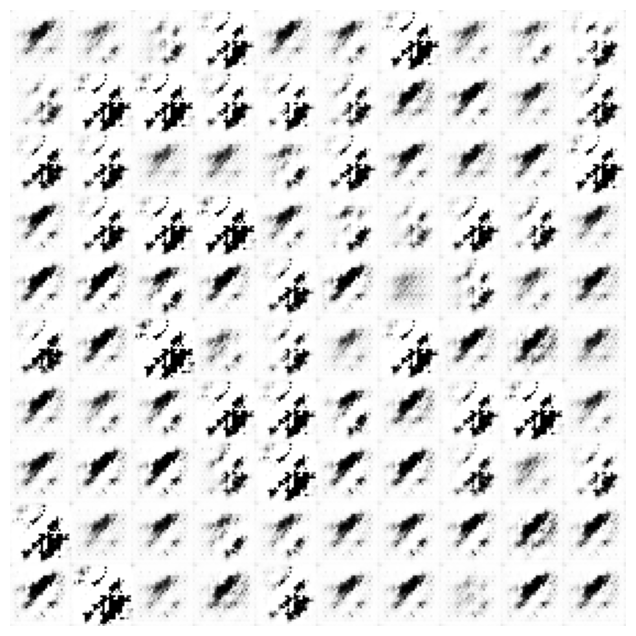

Epoch: 1, Generator loss: 18.5438, Discriminator loss: 0.1353
Epoch: 1, Generator loss: 14.9389, Discriminator loss: 0.0695
Epoch: 1, Generator loss: 15.2795, Discriminator loss: 0.0527
Epoch: 1, Generator loss: 19.9192, Discriminator loss: 0.1277
----------------------------------------------------------------
Epoch: 2, Generator loss: 18.6620, Discriminator loss: 0.0752
Epoch: 2, Generator loss: 17.4701, Discriminator loss: 0.0931
Epoch: 2, Generator loss: 21.2397, Discriminator loss: 0.0327
Epoch: 2, Generator loss: 12.1380, Discriminator loss: 0.3858
----------------------------------------------------------------
Epoch: 3, Generator loss: 14.7399, Discriminator loss: 0.1212
Epoch: 3, Generator loss: 21.1047, Discriminator loss: 0.0106
Epoch: 3, Generator loss: 14.0067, Discriminator loss: 0.1416
Epoch: 3, Generator loss: 10.9125, Discriminator loss: 0.0601
----------------------------------------------------------------
Epoch: 4, Generator loss: 15.1056, Discriminator loss: 0.1352

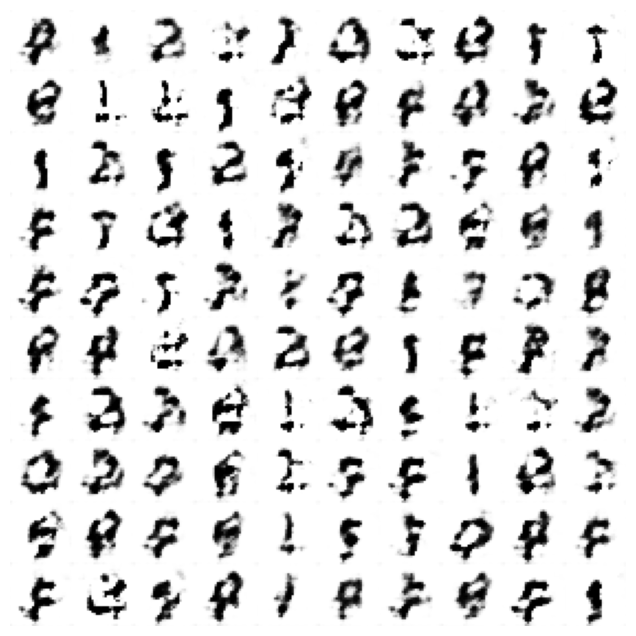

Epoch: 5, Generator loss: 13.7836, Discriminator loss: 0.2609
Epoch: 5, Generator loss: 23.8435, Discriminator loss: 0.2838
Epoch: 5, Generator loss: 17.9378, Discriminator loss: 0.0275
Epoch: 5, Generator loss: 29.8854, Discriminator loss: 0.0410
----------------------------------------------------------------
Epoch: 6, Generator loss: 20.9077, Discriminator loss: 0.1007
Epoch: 6, Generator loss: 23.8286, Discriminator loss: 0.0308
Epoch: 6, Generator loss: 17.3883, Discriminator loss: 0.1415
Epoch: 6, Generator loss: 14.6390, Discriminator loss: 0.1346
----------------------------------------------------------------
Epoch: 7, Generator loss: 17.4774, Discriminator loss: 0.0841
Epoch: 7, Generator loss: 27.7073, Discriminator loss: 0.0073
Epoch: 7, Generator loss: 13.5119, Discriminator loss: 0.0744
Epoch: 7, Generator loss: 20.4377, Discriminator loss: 0.0731
Epoch: 7, Generator loss: 45.0551, Discriminator loss: 0.2271
----------------------------------------------------------------

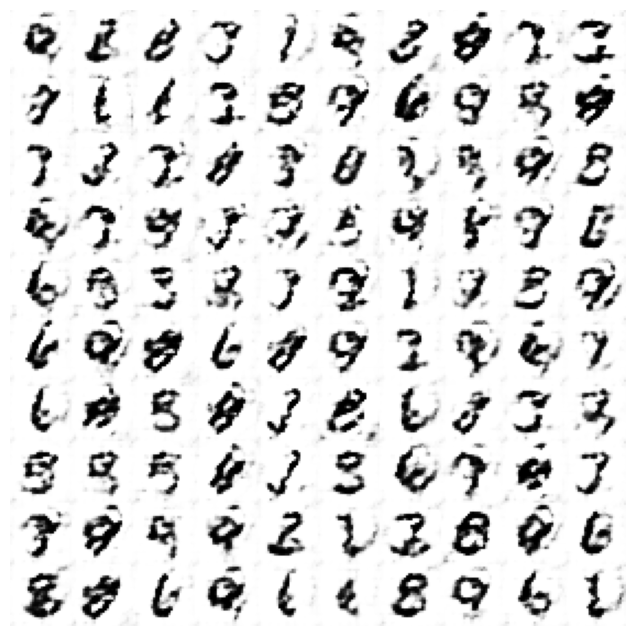

Epoch: 9, Generator loss: 28.1955, Discriminator loss: 0.0315
Epoch: 9, Generator loss: 17.9926, Discriminator loss: 0.0520
Epoch: 9, Generator loss: 20.5563, Discriminator loss: 0.1027
Epoch: 9, Generator loss: 15.8777, Discriminator loss: 0.0687
----------------------------------------------------------------
Epoch: 10, Generator loss: 12.0364, Discriminator loss: 0.0667
Epoch: 10, Generator loss: 29.8930, Discriminator loss: 0.0087
Epoch: 10, Generator loss: 14.9062, Discriminator loss: 0.2549
Epoch: 10, Generator loss: 24.3612, Discriminator loss: 0.2439
----------------------------------------------------------------
Epoch: 11, Generator loss: 14.5092, Discriminator loss: 0.0215
Epoch: 11, Generator loss: 4.6092, Discriminator loss: 0.4849
Epoch: 11, Generator loss: 8.3841, Discriminator loss: 0.2573
Epoch: 11, Generator loss: 29.9435, Discriminator loss: 0.1025
----------------------------------------------------------------
Epoch: 12, Generator loss: 18.7393, Discriminator loss:

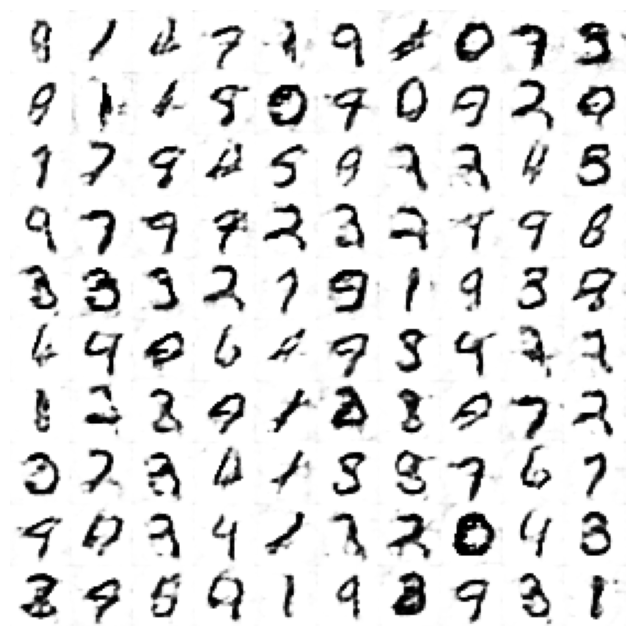

Epoch: 13, Generator loss: 19.6067, Discriminator loss: 0.6492
Epoch: 13, Generator loss: 15.1868, Discriminator loss: 0.3377
Epoch: 13, Generator loss: 25.3215, Discriminator loss: 0.2609
Epoch: 13, Generator loss: 15.2095, Discriminator loss: 0.2714
----------------------------------------------------------------
Epoch: 14, Generator loss: 13.9187, Discriminator loss: 0.2430
Epoch: 14, Generator loss: 6.8239, Discriminator loss: 0.3349
Epoch: 14, Generator loss: 26.3690, Discriminator loss: 0.1017
Epoch: 14, Generator loss: 36.5873, Discriminator loss: 1.8381
----------------------------------------------------------------
Epoch: 15, Generator loss: 21.0306, Discriminator loss: 0.1138
Epoch: 15, Generator loss: 13.1236, Discriminator loss: 0.0945
Epoch: 15, Generator loss: 17.5362, Discriminator loss: 0.2422
Epoch: 15, Generator loss: 6.6596, Discriminator loss: 0.1875
Epoch: 15, Generator loss: 16.3376, Discriminator loss: 0.0364
-----------------------------------------------------

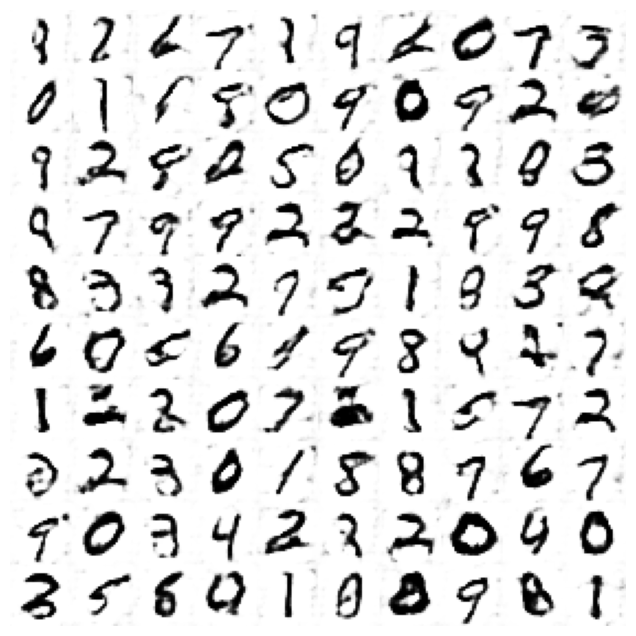

Epoch: 17, Generator loss: 15.6471, Discriminator loss: 0.4031
Epoch: 17, Generator loss: 17.2840, Discriminator loss: 0.0241
Epoch: 17, Generator loss: 21.5563, Discriminator loss: 0.0720
Epoch: 17, Generator loss: 5.8457, Discriminator loss: 0.6065
----------------------------------------------------------------
Epoch: 18, Generator loss: 12.3488, Discriminator loss: 0.2319
Epoch: 18, Generator loss: 14.2875, Discriminator loss: 0.1813
Epoch: 18, Generator loss: 18.7445, Discriminator loss: 0.1909
Epoch: 18, Generator loss: 13.6452, Discriminator loss: 0.2705
----------------------------------------------------------------
Epoch: 19, Generator loss: 21.1839, Discriminator loss: 0.1973
Epoch: 19, Generator loss: 17.6613, Discriminator loss: 0.2389
Epoch: 19, Generator loss: 18.2552, Discriminator loss: 0.1939
Epoch: 19, Generator loss: 14.8880, Discriminator loss: 0.0921
----------------------------------------------------------------
Epoch: 20, Generator loss: 23.7643, Discriminator 

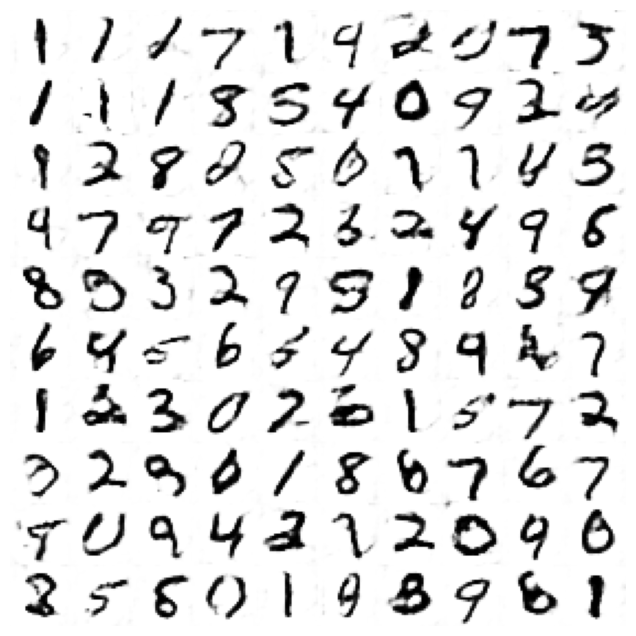

Epoch: 21, Generator loss: 9.6955, Discriminator loss: 0.3766
Epoch: 21, Generator loss: 16.8974, Discriminator loss: 0.2545
Epoch: 21, Generator loss: 22.6486, Discriminator loss: 0.3458
Epoch: 21, Generator loss: 16.5226, Discriminator loss: 0.2371
----------------------------------------------------------------
Epoch: 22, Generator loss: 14.1336, Discriminator loss: 0.3442
Epoch: 22, Generator loss: 15.3407, Discriminator loss: 0.1538
Epoch: 22, Generator loss: 7.6701, Discriminator loss: 0.4082
Epoch: 22, Generator loss: 9.7963, Discriminator loss: 0.1135
----------------------------------------------------------------
Epoch: 23, Generator loss: 20.4494, Discriminator loss: 0.4762
Epoch: 23, Generator loss: 13.6775, Discriminator loss: 0.1088
Epoch: 23, Generator loss: 21.9039, Discriminator loss: 0.6709
Epoch: 23, Generator loss: 19.1540, Discriminator loss: 0.3205
Epoch: 23, Generator loss: 14.8377, Discriminator loss: 0.5270
------------------------------------------------------

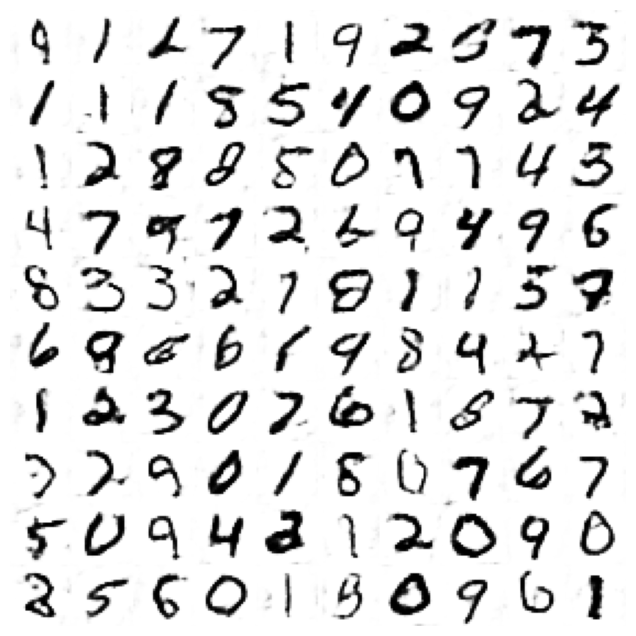

In [19]:
train(epochs)

## Visualization

In [28]:
filename = "dcgan_generation_over_time.mp4"
pil_to_video(grid_images, filename, fps=6)

In [29]:
display(Video(filename, embed=True))

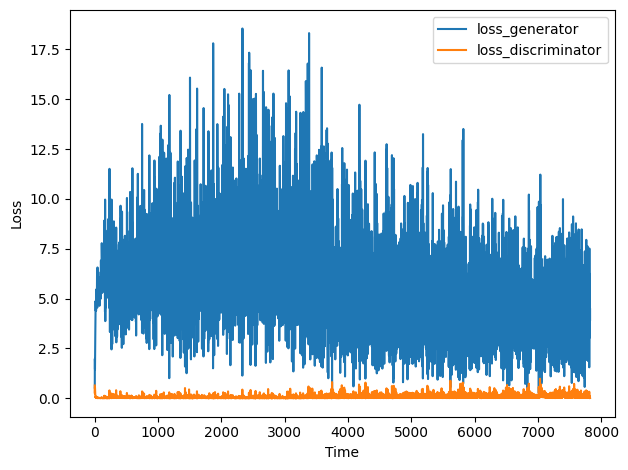

In [26]:
plt.plot(generator_losses, label="loss_generator")
plt.plot(discriminator_losses, label="loss_discriminator")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend()
plt.show()

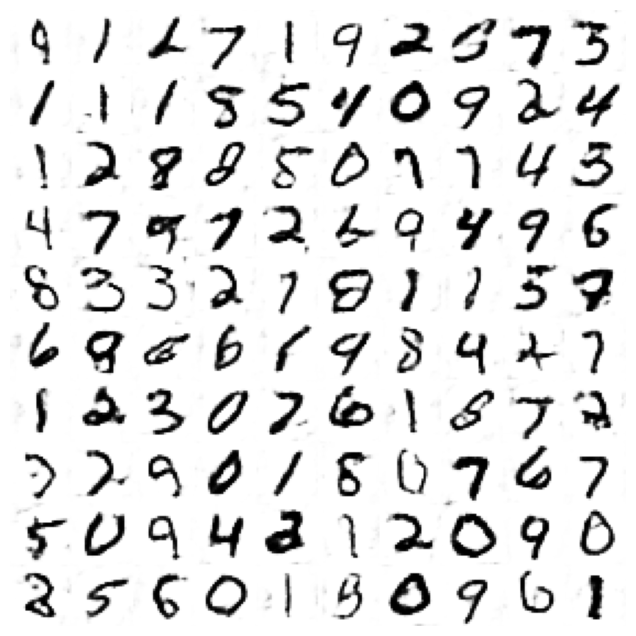

In [27]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(visualize(), cmap="binary")
plt.axis("off")
plt.show()